In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import random
from datetime import datetime
from faker import Faker

**Steps:**
1. [x] Decide the variables 
2. [x] Fake data for one student 
3. [x] Fake data for one class
4. [ ] Fake data for multiple classes 
5. [ ] Fake data for multiple terms 

---
### Decide the variables:

In [2]:
# Basic_Info:
    # id 
    # f_name
    # l_name
    # gender
    # race
    # birth_dt
    # address
    # email
    
# Academic_Performance:
    # Grades of quizzes, tests, home assignments
    # Attendance
    # Number of on-time, late, and missed assignments
    # Number of accesses to LMS
    # Average time spent on LMS
    # Messages on LMS (for example, number of questions and responses on the discussion forum)

---
### Fake data for one student:

In [3]:
import bisect

def bi_search(arr, x): # binary search
    i = bisect.bisect(arr, x)-1
    if i != len(arr) and arr[i] == x:
        return i
    return False

bi_search(np.asarray([1, 2, 5, 8]), 6)

False

In [4]:
def ewma_predict(series, span=3, jump=1): # jump is the diff in time bw the date of prediction & the last observation
    if len(series) == 1: #if the series has only 1 element
        return series.iloc[0]
    
    s_clone = series # shallow copy for efficiency
    
    if s_clone.iloc[-1] == 0:   # if the most recent grade is from a missed assigment, i.e. grade = 0
        s_clone = series.copy() # deep copy
        s_clone.iloc[-1] = s_clone.ewm(span=span).mean().iloc[-1]
        # set that grade equal to the ewma
        # this is to alleviate the disastrous effect of a grade of 0 
    
    inter = s_clone.ewm(span=span).mean().iloc[-1]
    
    differences = s_clone.diff()
    slope = differences.ewm(span=span).mean().iloc[-1]
    
    return inter + slope*jump

In [5]:
def miss_chance(index, cum_mean_grade, gra_slope=0.5):
    if index < 2: # first few assignments
        return random.betavariate(1.1, 15)*100 # very unlikely to miss on the first few assignments
    
    if cum_mean_grade >= 60: # D- or higher
        missed = random.betavariate(1.1, 10)*100 - gra_slope*np.power(cum_mean_grade, 0.73)
    else:
        missed = random.betavariate(1.5, 8)*100 - (gra_slope-0.1)*np.power(cum_mean_grade, 0.73)
        # more likely to miss assignment if mean grade is < 60
    
    return missed

In [6]:
def fake_student_grades(grade1_mu, grade1_std, n_tests, n_home, last_home_idx, n_exams, exam1_idx):
    total_n_grades = n_home + n_tests + n_exams 
    # total number of grades: home assignments, tests, exams
    # the indexes of range(0, total_n_grades) are the "positions" of each grade
    
    home_pos = np.round(np.linspace(start=0, stop=last_home_idx, num=n_home)).astype(int)
    # the "positions" of the home assignments
    # suppose that the 1st grade is from a home assignments: start=0
    
    exam_pos = np.round(np.linspace(start=exam1_idx, stop=total_n_grades-1, num=n_exams)).astype(int)
    # the "positions" of the exams
    # suppose that the final grade is from an exam: stop=total_n_tests-1
    
    for i, pos in enumerate(exam_pos):
        if bi_search(home_pos, pos): # check if the positions of home assignments and exams overlap 
            home_pos[i] -= 1         # if so, subtract the position of the home assignment by 1
    
    home_exam_pos = np.concatenate((home_pos, exam_pos))
    
    test_pos = [p for p in range(total_n_grades) if p not in home_exam_pos]
    # the rest is positions of the tests
    
    grade1 = int(round(random.gauss(grade1_mu, grade1_std)))
    grade1 = grade1 if grade1 <= 100 else 100 # can't be > 100
    grade1 = grade1 if grade1 >= 0 else 0 # can't be < 0
    grade_series = pd.Series([grade1])
    
    var_std = random.uniform(1, 3)
    # print("Variation std:", var_std)
    
    for g in range(1, total_n_grades):
        span = 3
        if bi_search(home_pos, g): # if it's a home assignment:
            index = bi_search(home_pos, g)
            cum_mean_grade = grade_series.mean()
            
            if miss_chance(index, cum_mean_grade)>40:
                grade_series = grade_series.append(pd.Series(0)) # missed if miss_chance > 40%
                continue

            variation = random.gauss(1, var_std) # grades of home assignments tend to be higher: mu=1
        
        elif bi_search(test_pos, g): # test
            variation = random.gauss(0, var_std)
        
        else: # exam
            variation = random.gauss(-1, var_std) # grades of exams tend to be lower: mu=-1
            span = 5 # exams tend to cover a larger range of content
        
        next_grade = ewma_predict(grade_series, span) + variation
        next_grade = next_grade if next_grade <= 100 else 100 # can't be > 100
        next_grade = next_grade if next_grade >= 0 else 0 # can't be < 0
        next_grade = pd.Series(next_grade).round()
        
        grade_series = grade_series.append(next_grade)
        #print(grade_series)
    
    home_series = grade_series.iloc[home_pos]
    exam_series = grade_series.iloc[exam_pos]
    test_series = grade_series.iloc[test_pos]
    
    # reset index:
    for s in [home_series, exam_series, test_series]:
        s.reset_index(inplace=True, drop=True)
        
    return grade_series, home_series, exam_series, test_series

args = { 
    'grade1_mu':78, 
    'grade1_std': 5, 
    'n_tests': 2,  
    'n_home': 3, 
    'last_home_idx': 4, # starts at 0
    'n_exams': 0, 
    'exam1_idx': 0      # if there's no exam, put 0
}

fake_student_grades(**args)

(0    78.0
 0    75.0
 0    73.0
 0    70.0
 0    70.0
 dtype: float64,
 0    78.0
 1    73.0
 2    70.0
 dtype: float64,
 Series([], dtype: float64),
 0    75.0
 1    70.0
 dtype: float64)

In [7]:
def fake_student_submission(mean_grade, home_grade_series, ontime_slope=0.3, **kwargs):
    missed = home_grade_series.loc[home_grade_series==0].count()
    missed = missed*100/len(home_grade_series)
    missed = float('{:.2f}'.format(missed)) # round to 2 decimal places
    
    ontime_and_late = 100 - missed 
    
    ontime_slope = ontime_slope if ontime_slope >= 0.3 else 0.3
    # 0.3 is the default slope bw grade and on_time submissions
    # some classes may have a stricter policy regarding deadlines
    
    if mean_grade >= 70: # C- or higher
        on_time = random.betavariate(13, 2)*100 + ontime_slope*np.power(mean_grade, 0.73)
    else:
        on_time = random.betavariate(60, 25)*100 + (ontime_slope-0.1)*np.power(mean_grade, 0.73)
        # more likely to have late submissions if mean grade is < 70
        # the relation bw grade and on-submission is weaker: gra_slode-0.1
    
    on_time = on_time if on_time<100 else 100 # cannot be > 100
    on_time = (on_time*ontime_and_late)/100
    on_time = float('{:.2f}'.format(on_time))
    
    late = ontime_and_late - on_time
    late = float('{:.2f}'.format(late))
    
    return on_time, late, missed

fake_student_submission(70, pd.Series([65, 60, 10, 55, 67]))

(95.19, 4.81, 0.0)

In [8]:
def fake_student_attendance(mean_grade, att_min_gra_slope=0.4, att_max_gra_slope=0.6, 
                            hi_beta_para=(13, 2), lo_beta_para=(30, 25), **kwargs):
    # slope is from a uniform distribution
    slope = random.uniform(att_min_gra_slope, att_max_gra_slope)
    # print('slope:', slope)

    # intercept is from a beta distribution
    if mean_grade >= 70: # C- or higher
        inter = random.betavariate(hi_beta_para[0], hi_beta_para[1]) * 100
        attendance = np.power(mean_grade, 0.7)*slope + inter
    else:
        inter = random.betavariate(lo_beta_para[0], lo_beta_para[1]) * 100
        attendance = np.power(mean_grade, 0.6)*slope + inter
    # print('Inter:', inter)
     
    attendance = attendance if attendance<100 else 100 # cannot be > 100
    attendance = float('{:.2f}'.format(attendance))    # round to 2 decimal places
    
    return attendance

print(fake_student_attendance(90))
print(fake_student_attendance(60))

100.0
70.44


In [9]:
def fake_student_LMS_accesses(mean_grade, acc_gra_slope_mu=1, acc_gra_slope_std=0.1, 
                              acc_inter_mu=3, acc_inter_std=0.1, **kwargs): 
    # weekly LMS accesses
    gra_slope = random.gauss(acc_gra_slope_mu, acc_gra_slope_std)
    inter = random.gauss(acc_inter_mu, acc_inter_std) # account for other random factors than grade
    
    # the default acc_inter_mu = 3
    # given that acc_gra_slope_mu = 1
    # a student with a grade of 90 is expected to have 6 accesses/week
    # to adjust this expectation, change the acc_inter_mu
    
    weekly_accesses = gra_slope*(mean_grade/10) - inter
    weekly_accesses = weekly_accesses if weekly_accesses > 0 else 0.1
    # if the returned result is =< 0, that means we get a very small value
    weekly_accesses = float('{:.2f}'.format(weekly_accesses))
    
    return weekly_accesses

print(fake_student_LMS_accesses(90))
print(fake_student_LMS_accesses(60))
        
# this model is strong!
# given that the slope can get as low as 0.6:
# 6*0.6 = 3.6 - 3 = 0.6 > 0.1

5.98
3.73


In [10]:
def fake_student_LMS_time(mean_grade, weekly_accesses, tim_gra_slope_mu=1, norm_tim_gra_slope_std=0.1, 
                          tim_inter_mu=2, tim_inter_std=0.1, tim_acc_slope_mu=0.3, tim_acc_slope_std=0.01, **kwargs):
    
    # average time spent per session in minutes
        
    # the relation to grade is not clear
    # a high grade may indicate that a student is intelligent & understands things quickly
    # or she's diligent and hard-working
    
    if mean_grade >= 83: # B or higher
        gra_slope = random.gauss(tim_gra_slope_mu, norm_tim_gra_slope_std+0.05)
        # the slope varies more for students with high grades
    else:
        gra_slope = random.gauss(tim_gra_slope_mu, norm_tim_gra_slope_std)
        
    acc_slope = random.gauss(tim_acc_slope_mu, tim_acc_slope_std) # higher freq of accesses often means less session time
    inter = random.gauss(tim_inter_mu, tim_inter_std) # account for other random factors than grade
    
    session_time = gra_slope*(mean_grade/10) - acc_slope*np.power(1.2, weekly_accesses) - inter
    
    session_time = session_time if session_time > 0 else 0.1 
    # if the returned result is =< 0, that means we get a very small value
    session_time = float('{:.2f}'.format(session_time))
    
    # adjust the time_inter_mu to raise/lower the (expected) session time
    
    return session_time

fake_student_LMS_time(90, 6)

5.18

In [11]:
def fake_student_LMS_mess(mean_grade, n_mess_mu, mess_gra_slope=0.13, **kwargs): 
    # n_mess_mu is the mean num of messages of the whole class
    if mean_grade >= 70: # C- or higher
        lambd = 1.0/(n_mess_mu+0.5)
        # the mean number of messages is higher for students with score >= 70
    else:
        n_mess_mu = n_mess_mu-2
        n_mess_mu = n_mess_mu if n_mess_mu > 0 else 0.1
        lambd = 1.0/(n_mess_mu)
        # the mean number of messages is lower for students with score < 70
        mess_gra_slope = mess_gra_slope - 0.03
        # the relation bw grade and number of messages is also weaker
    
    inter = random.expovariate(lambd) # intercept is from an exponential dist
    
    mess_num = mess_gra_slope*(mean_grade/10) + (inter - 7*mess_gra_slope)
    mess_num = int(round(mess_num))
    mess_num = mess_num if mess_num > 0 else 0
    
    return mess_num

print(fake_student_LMS_mess(90, 3))
print(fake_student_LMS_mess(70, 3))
print(fake_student_LMS_mess(60, 3))

3
8
2


(array([1., 2., 1., 7., 6., 2., 3., 5., 2., 1.]),
 array([52. , 55.9, 59.8, 63.7, 67.6, 71.5, 75.4, 79.3, 83.2, 87.1, 91. ]),
 <a list of 10 Patch objects>)

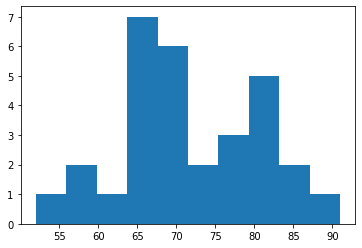

In [12]:
class_size = 30
quiz1_grades = [] 

for i in range(class_size):
    quiz1_grades.append(int(round(random.gauss(mu=75, sigma=10))))
    
plt.hist(quiz1_grades)

(array([1., 5., 1., 8., 6., 3., 3., 2., 0., 1.]),
 array([1.69 , 2.287, 2.884, 3.481, 4.078, 4.675, 5.272, 5.869, 6.466,
        7.063, 7.66 ]),
 <a list of 10 Patch objects>)

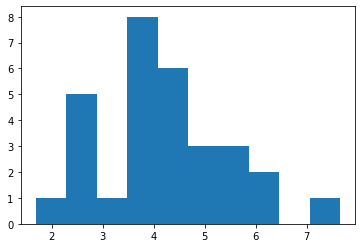

In [13]:
accesses = [fake_student_LMS_accesses(g) for g in quiz1_grades]
plt.hist(accesses)

(array([18.,  6.,  3.,  0.,  1.,  0.,  0.,  0.,  1.,  1.]),
 array([ 0. ,  1.4,  2.8,  4.2,  5.6,  7. ,  8.4,  9.8, 11.2, 12.6, 14. ]),
 <a list of 10 Patch objects>)

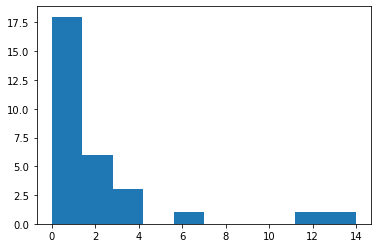

In [14]:
mess = [fake_student_LMS_mess(g, 3) for g in quiz1_grades]
plt.hist(mess)

---
### Fake data for one class:

In [15]:
def fake_class_basic_info(class_size):
    columns = ['id', 'f_name', 'l_name', 'gender', 'race', 'birth_dt', 'address', 'email']
    info_df = pd.DataFrame(columns=columns)
    
    possible_races = ['White', 'Black', 'Native', 'Asian', 'Pacific Islander', 'Mixed']
    race_prob = [0.763, 0.134, 0.013, 0.059, 0.002, 0.029]
    
    # Faker.seed(1234) # for producing the same results 
    fake = Faker()
    
    for s in range(class_size):
        student = {
            'id': fake.ssn(),
            'l_name': fake.last_name(),
            'gender': random.choice(['M', 'F']),
            'race': np.random.choice(possible_races, replace=True, p=race_prob),
            'birth_dt': fake.date_between_dates(date_start=datetime(1997, 1, 1), 
                                                date_end=datetime(2001, 12, 31)),
            'address': fake.address(),
            'email': fake.free_email()
        }    
        student['f_name'] = fake.first_name_male() if student['gender']=='M' else fake.first_name_female()
        
        info_df = info_df.append(student, ignore_index=True)
    
    return info_df

class20_basic_info = fake_class_basic_info(30)
class20_basic_info

id       f_name     l_name gender    race    birth_dt  \
0   632-75-6329      Melanie      Lucas      F   Asian  1997-01-25   
1   241-17-2333       Martin   Williams      M   White  2000-07-05   
2   834-48-1203      Theresa   Shepherd      F   White  1997-02-11   
3   472-14-6168      Spencer     Miller      M   White  1999-06-16   
4   143-19-7329        Nancy  Contreras      F   White  1999-04-04   
5   884-81-3452       Regina   Thompson      F   Black  1997-02-03   
6   621-92-9431         John      Casey      M   White  2001-01-26   
7   290-80-5773       Teresa   Gonzalez      F   White  1998-07-02   
8   445-58-8339        Susan      White      F   White  1998-04-23   
9   607-75-0014      Natalie       Dyer      F   White  1998-08-31   
10  667-05-8274      Michael    Mcguire      M   White  1997-07-29   
11  845-71-2146  Christopher     Peters      M   White  2000-02-26   
12  199-29-4464        Laura    Stanton      F   White  1998-08-02   
13  008-54-8784        Linda   Crawford      F   White  2000-02-20   
14  266-35-1015       Nicole      Zhang      F   White  1997-12-05   
15  125-48-8151      Jeffrey      Haley      M   White  1997-11-13   
16  815-52-5343     Patricia      Carey      F   White  1999-06-28   
17  042-23-0843    Christine     Burton      F   White  1997-05-02   
18  872-89-9399        Nancy      Reese      F   White  1998-10-23   
19  020-92-8476        Diane    Salazar      F   White  1998-12-02   
20  646-11-5445     Reginald      Scott      M   Asian  1997-03-16   
21  788-04-5335        Brian       Sims      M   Black  2001-02-27   
22  876-64-6443       Robert   Peterson      M   White  1998-10-30   
23  072-23-2600      Gabriel    Jackson      M   White  1997-05-23   
24  497-63-3157      Douglas     Hughes      M   White  1998-07-26   
25  223-02-1541     Michelle     Torres      F  Native  2000-06-08   
26  891-83-9812     Courtney     Gaines      F   Black  1997-06-13   
27  218-50-6294       Austin       Hall      M   White  2000-09-03   
28  719-59-3735      Michael   Williams      M   White  2001-06-12   
29  869-97-1923        Frank   Robinson      M   White  2001-12-18   

                                              address  \
0                    Unit 7490 Box 6082\nDPO AE 04574   
1                            USCGC Ford\nFPO AP 56061   
2           5451 Tiffany Springs\nJamesstad, NJ 26693   
3            45984 Oliver Knolls\nPort Ryan, TX 04552   
4   658 Cohen Extension\nNorth Kathleenburgh, NY 7...   
5   576 Tiffany Road Suite 554\nSouth Jamesmouth, ...   
6   694 Camacho Circles Apt. 374\nEast Gilbert, MA...   
7   619 Michael Crescent Suite 175\nJacobport, OK ...   
8   090 Wilkins Estates Suite 551\nRyanview, DC 81532   
9           176 Silva Cape\nWest Traceyfurt, ID 96499   
10  52719 Howard Centers Suite 787\nBenjaminstad, ...   
11    016 Matthew Shores Apt. 331\nNew Greg, DC 27311   
12                   PSC 1411, Box 1508\nAPO AP 20017   
13           2571 Henderson Burg\nShaneport, NJ 37714   
14  120 Davis River Apt. 960\nSouth Rickyfurt, CA ...   
15  819 Woods Extension\nLake Kimberlymouth, CA 48364   
16         6674 Michael Lane\nHernandezview, UT 03257   
17        8130 Caroline Wells\nEast Anthony, IN 33528   
18                   PSC 0224, Box 2143\nAPO AP 00943   
19  632 Willis Circle Suite 360\nSamuelbury, DC 83347   
20           072 Zhang Turnpike\nJonesmouth, ND 32855   
21       033 Young Passage\nWest Kevinville, CO 82827   
22                   Unit 4819 Box 1263\nDPO AE 20191   
23                   Unit 3903 Box 7398\nDPO AE 34743   
24                   PSC 0242, Box 6263\nAPO AA 91215   
25            750 Evans Walks\nMartinezland, VT 58504   
26      728 Jones Ports\nNorth Veronicabury, MA 72734   
27         287 Brandon Streets\nMatthewstad, MO 87994   
28    512 Scott Courts Apt. 556\nLake James, OK 30463   
29  09961 Trujillo Causeway Suite 480\nJenniferbur...   

                          email  
0   colechristopher@hotmail.com  
1     

In [16]:
def fake_class_performance(class_size, n_mess_mu, grade1_mu, grade1_std, n_total_tests, n_avail_tests, 
                           n_total_home, n_avail_home, latest_home_idx, 
                           n_total_exams, n_avail_exams, exam1_idx, **paras):
    
    home_cols = ['home{}'.format(i+1) for i in range(n_total_home)]
    test_cols = ['test{}'.format(i+1) for i in range(n_total_tests)]
    exam_cols = ['exam{}'.format(i+1) for i in range(n_total_exams)]
    
    columns = ['ontime', 'late', 'missed', 'attendance', 'LMS_accesses', 'LMS_time', 'LMS_mess']
    columns = home_cols + test_cols + exam_cols + columns
        
    performance_df = pd.DataFrame(columns=columns)
    
    for st in range(class_size):
        st_all_gr, st_ho_gr, st_exam_gr, st_test_gr = fake_student_grades(grade1_mu, grade1_std, n_avail_tests, n_avail_home, 
                                                                          latest_home_idx, n_avail_exams, exam1_idx)
                
        ho_dict = {'home{}'.format(i+1): hg for i, hg in st_ho_gr.items()}
        test_dict = {'test{}'.format(i+1): tg for i, tg in st_test_gr.items()}
        exam_dict = {'exam{}'.format(i+1): eg for i, eg in st_exam_gr.items()}
        
        mean_gr = st_all_gr.mean()
        
        st_ontime, st_late, st_missed = fake_student_submission(mean_gr, st_ho_gr, **paras)
        st_attendance = fake_student_attendance(mean_gr, **paras)
        st_LMS_accesses = fake_student_LMS_accesses(mean_gr, **paras)
        st_LMS_time = fake_student_LMS_time(mean_gr, st_LMS_accesses, **paras)
        st_LMS_mess = fake_student_LMS_mess(mean_gr, n_mess_mu, **paras)
        
        student = {
            'ontime': st_ontime,
            'late': st_late,
            'missed': st_missed,
            'attendance': st_attendance,
            'LMS_accesses': st_LMS_accesses,
            'LMS_time': st_LMS_time,
            'LMS_mess': st_LMS_mess
        }
        
        student = {**student, **ho_dict, **test_dict, **exam_dict}
        
        performance_df = performance_df.append(student, ignore_index=True)
    
    return performance_df
        

args = {
    'class_size': 30, 
    'n_mess_mu': 2, 
    'grade1_mu':78, 
    'grade1_std': 5, 
    'n_total_tests': 5, 
    'n_avail_tests': 2, 
    'n_total_home': 5, 
    'n_avail_home': 3, 
    'latest_home_idx': 4, # idx starts at 0  
    'n_total_exams': 2, 
    'n_avail_exams': 1, 
    'exam1_idx': 3,       # idx starts at 0
}

class20_performance = fake_class_performance(**args)
class20_performance

home1  home2  home3  home4  home5  test1  test2  test3  test4  test5  \
0    78.0   78.0   77.0    NaN    NaN   78.0   78.0    NaN    NaN    NaN   
1    79.0   77.0   76.0    NaN    NaN   77.0   75.0    NaN    NaN    NaN   
2    79.0   81.0   86.0    NaN    NaN   79.0   86.0    NaN    NaN    NaN   
3    77.0   74.0   77.0    NaN    NaN   75.0   77.0    NaN    NaN    NaN   
4    80.0   83.0   83.0    NaN    NaN   80.0   86.0    NaN    NaN    NaN   
5    83.0   84.0   78.0    NaN    NaN   82.0   76.0    NaN    NaN    NaN   
6    90.0   90.0   92.0    NaN    NaN   89.0   91.0    NaN    NaN    NaN   
7    77.0   72.0   70.0    NaN    NaN   74.0   70.0    NaN    NaN    NaN   
8    67.0   60.0   56.0    NaN    NaN   62.0   55.0    NaN    NaN    NaN   
9    79.0   81.0   78.0    NaN    NaN   79.0   79.0    NaN    NaN    NaN   
10   76.0   75.0   72.0    NaN    NaN   75.0   77.0    NaN    NaN    NaN   
11   75.0   73.0   69.0    NaN    NaN   75.0   73.0    NaN    NaN    NaN   
12   73.0   72.0   73.0    NaN    NaN   72.0   74.0    NaN    NaN    NaN   
13   74.0   72.0   69.0    NaN    NaN   72.0   70.0    NaN    NaN    NaN   
14   78.0   76.0   73.0    NaN    NaN   76.0   75.0    NaN    NaN    NaN   
15   85.0   82.0   83.0    NaN    NaN   81.0   86.0    NaN    NaN    NaN   
16   81.0   74.0   78.0    NaN    NaN   77.0   76.0    NaN    NaN    NaN   
17   80.0   76.0   78.0    NaN    NaN   78.0   76.0    NaN    NaN    NaN   
18   74.0   69.0   66.0    NaN    NaN   72.0   64.0    NaN    NaN    NaN   
19   88.0   79.0   75.0    NaN    NaN   83.0   74.0    NaN    NaN    NaN   
20   70.0   68.0   65.0    NaN    NaN   67.0   65.0    NaN    NaN    NaN   
21   73.0   72.0   70.0    NaN    NaN   72.0   71.0    NaN    NaN    NaN   
22   85.0   77.0   78.0    NaN    NaN   80.0   77.0    NaN    NaN    NaN   
23   85.0   85.0   85.0    NaN    NaN   84.0   85.0    NaN    NaN    NaN   
24   74.0   69.0   63.0    NaN    NaN   72.0   61.0    NaN    NaN    NaN   
25   83.0   77.0   83.0    NaN    NaN   82.0   82.0    NaN    NaN    NaN   
26   78.0   78.0   77.0    NaN    NaN   77.0   76.0    NaN    NaN    NaN   
27   78.0   78.0   76.0    NaN    NaN   75.0   73.0    NaN    NaN    NaN   
28   76.0   80.0   81.0    NaN    NaN   79.0   83.0    NaN    NaN    NaN   
29   76.0   74.0   73.0    NaN    NaN   75.0   72.0    NaN    NaN    NaN   

    exam1  exam2  ontime   late  missed  attendance  LMS_accesses  LMS_time  \
0    78.0    NaN   80.80  19.20     0.0       95.07          5.67      4.65   
1    75.0    NaN  100.00   0.00     0.0      100.00          3.69      4.62   
2    83.0    NaN   94.99   5.01     0.0       96.72          5.46      5.74   
3    77.0    NaN  100.00   0.00     0.0      100.00          4.83      4.38   
4    83.0    NaN   85.31  14.69     0.0       91.96          5.20      4.03   
5    80.0    NaN  100.00   0.00     0.0       98.40          5.11      6.71   
6    90.0    NaN   91.72   8.28     0.0       92.31          4.70      6.17   
7    70.0    NaN  100.00   0.00     0.0      100.00          4.47      4.10   
8    57.0    NaN   72.57  27.43     0.0       78.38          3.22      3.56   
9    78.0    NaN  100.00   0.00     0.0      100.00          5.48      4.56   
10   71.0    NaN  100.00   0.00     0.0       89.68          3.32      4.60   
11   70.0    NaN   92.32   7.68     0.0      100.00          2.83      4.52   
12   72.0    NaN  100.00   0.00     0.0       77.13          3.96      5.20   
13   70.0    NaN   96.46   3.54     0.0       95.32          3.69      4.24   
14   75.0    NaN   97.32   2.68     0.0      100.00          3.99      4.99   
15   79.0    NaN   98.82   1.18     0.0       84.62          5.27      5.31   
16   75.0    NaN   83.34  16.66     0.0      100.00          3.95      4.98   
17   76.0    NaN   79.36  20.64     0.0       83.37          4.52      4.98   
18   66.0    NaN   82.79  17.21     0.0       71.21          3.01      3.30   
19   75.0    NaN   91.26   8.74     0.0      100.00          4.60  

In [17]:
# join on index to combine the two df
# assume there's no relationship bw basic info & academic performance

class20_df = class20_basic_info.join(class20_performance)
class20_df

id       f_name     l_name gender    race    birth_dt  \
0   632-75-6329      Melanie      Lucas      F   Asian  1997-01-25   
1   241-17-2333       Martin   Williams      M   White  2000-07-05   
2   834-48-1203      Theresa   Shepherd      F   White  1997-02-11   
3   472-14-6168      Spencer     Miller      M   White  1999-06-16   
4   143-19-7329        Nancy  Contreras      F   White  1999-04-04   
5   884-81-3452       Regina   Thompson      F   Black  1997-02-03   
6   621-92-9431         John      Casey      M   White  2001-01-26   
7   290-80-5773       Teresa   Gonzalez      F   White  1998-07-02   
8   445-58-8339        Susan      White      F   White  1998-04-23   
9   607-75-0014      Natalie       Dyer      F   White  1998-08-31   
10  667-05-8274      Michael    Mcguire      M   White  1997-07-29   
11  845-71-2146  Christopher     Peters      M   White  2000-02-26   
12  199-29-4464        Laura    Stanton      F   White  1998-08-02   
13  008-54-8784        Linda   Crawford      F   White  2000-02-20   
14  266-35-1015       Nicole      Zhang      F   White  1997-12-05   
15  125-48-8151      Jeffrey      Haley      M   White  1997-11-13   
16  815-52-5343     Patricia      Carey      F   White  1999-06-28   
17  042-23-0843    Christine     Burton      F   White  1997-05-02   
18  872-89-9399        Nancy      Reese      F   White  1998-10-23   
19  020-92-8476        Diane    Salazar      F   White  1998-12-02   
20  646-11-5445     Reginald      Scott      M   Asian  1997-03-16   
21  788-04-5335        Brian       Sims      M   Black  2001-02-27   
22  876-64-6443       Robert   Peterson      M   White  1998-10-30   
23  072-23-2600      Gabriel    Jackson      M   White  1997-05-23   
24  497-63-3157      Douglas     Hughes      M   White  1998-07-26   
25  223-02-1541     Michelle     Torres      F  Native  2000-06-08   
26  891-83-9812     Courtney     Gaines      F   Black  1997-06-13   
27  218-50-6294       Austin       Hall      M   White  2000-09-03   
28  719-59-3735      Michael   Williams      M   White  2001-06-12   
29  869-97-1923        Frank   Robinson      M   White  2001-12-18   

                                              address  \
0                    Unit 7490 Box 6082\nDPO AE 04574   
1                            USCGC Ford\nFPO AP 56061   
2           5451 Tiffany Springs\nJamesstad, NJ 26693   
3            45984 Oliver Knolls\nPort Ryan, TX 04552   
4   658 Cohen Extension\nNorth Kathleenburgh, NY 7...   
5   576 Tiffany Road Suite 554\nSouth Jamesmouth, ...   
6   694 Camacho Circles Apt. 374\nEast Gilbert, MA...   
7   619 Michael Crescent Suite 175\nJacobport, OK ...   
8   090 Wilkins Estates Suite 551\nRyanview, DC 81532   
9           176 Silva Cape\nWest Traceyfurt, ID 96499   
10  52719 Howard Centers Suite 787\nBenjaminstad, ...   
11    016 Matthew Shores Apt. 331\nNew Greg, DC 27311   
12                   PSC 1411, Box 1508\nAPO AP 20017   
13           2571 Henderson Burg\nShaneport, NJ 37714   
14  120 Davis River Apt. 960\nSouth Rickyfurt, CA ...   
15  819 Woods Extension\nLake Kimberlymouth, CA 48364   
16         6674 Michael Lane\nHernandezview, UT 03257   
17        8130 Caroline Wells\nEast Anthony, IN 33528   
18                   PSC 0224, Box 2143\nAPO AP 00943   
19  632 Willis Circle Suite 360\nSamuelbury, DC 83347   
20           072 Zhang Turnpike\nJonesmouth, ND 32855   
21       033 Young Passage\nWest Kevinville, CO 82827   
22                   Unit 4819 Box 1263\nDPO AE 20191   
23                   Unit 3903 Box 7398\nDPO AE 34743   
24                   PSC 0242, Box 6263\nAPO AA 91215   
25            750 Evans Walks\nMartinezland, VT 58504   
26      728 Jones Ports\nNorth Veronicabury, MA 72734   
27         287 Brandon Streets\nMatthewstad, MO 87994   
28    512 Scott Courts Apt. 556\nLake James, OK 30463   
29  09961 Trujillo Causeway Suite 480\nJenniferbur...   

                          email  home1  home2  ...  test5  exam1  exam2  \

In [18]:
class20_df['course_code'] = 'CS_320'
class20_df['term_code'] = 'SP_2020' 
class20_df

id       f_name     l_name gender    race    birth_dt  \
0   632-75-6329      Melanie      Lucas      F   Asian  1997-01-25   
1   241-17-2333       Martin   Williams      M   White  2000-07-05   
2   834-48-1203      Theresa   Shepherd      F   White  1997-02-11   
3   472-14-6168      Spencer     Miller      M   White  1999-06-16   
4   143-19-7329        Nancy  Contreras      F   White  1999-04-04   
5   884-81-3452       Regina   Thompson      F   Black  1997-02-03   
6   621-92-9431         John      Casey      M   White  2001-01-26   
7   290-80-5773       Teresa   Gonzalez      F   White  1998-07-02   
8   445-58-8339        Susan      White      F   White  1998-04-23   
9   607-75-0014      Natalie       Dyer      F   White  1998-08-31   
10  667-05-8274      Michael    Mcguire      M   White  1997-07-29   
11  845-71-2146  Christopher     Peters      M   White  2000-02-26   
12  199-29-4464        Laura    Stanton      F   White  1998-08-02   
13  008-54-8784        Linda   Crawford      F   White  2000-02-20   
14  266-35-1015       Nicole      Zhang      F   White  1997-12-05   
15  125-48-8151      Jeffrey      Haley      M   White  1997-11-13   
16  815-52-5343     Patricia      Carey      F   White  1999-06-28   
17  042-23-0843    Christine     Burton      F   White  1997-05-02   
18  872-89-9399        Nancy      Reese      F   White  1998-10-23   
19  020-92-8476        Diane    Salazar      F   White  1998-12-02   
20  646-11-5445     Reginald      Scott      M   Asian  1997-03-16   
21  788-04-5335        Brian       Sims      M   Black  2001-02-27   
22  876-64-6443       Robert   Peterson      M   White  1998-10-30   
23  072-23-2600      Gabriel    Jackson      M   White  1997-05-23   
24  497-63-3157      Douglas     Hughes      M   White  1998-07-26   
25  223-02-1541     Michelle     Torres      F  Native  2000-06-08   
26  891-83-9812     Courtney     Gaines      F   Black  1997-06-13   
27  218-50-6294       Austin       Hall      M   White  2000-09-03   
28  719-59-3735      Michael   Williams      M   White  2001-06-12   
29  869-97-1923        Frank   Robinson      M   White  2001-12-18   

                                              address  \
0                    Unit 7490 Box 6082\nDPO AE 04574   
1                            USCGC Ford\nFPO AP 56061   
2           5451 Tiffany Springs\nJamesstad, NJ 26693   
3            45984 Oliver Knolls\nPort Ryan, TX 04552   
4   658 Cohen Extension\nNorth Kathleenburgh, NY 7...   
5   576 Tiffany Road Suite 554\nSouth Jamesmouth, ...   
6   694 Camacho Circles Apt. 374\nEast Gilbert, MA...   
7   619 Michael Crescent Suite 175\nJacobport, OK ...   
8   090 Wilkins Estates Suite 551\nRyanview, DC 81532   
9           176 Silva Cape\nWest Traceyfurt, ID 96499   
10  52719 Howard Centers Suite 787\nBenjaminstad, ...   
11    016 Matthew Shores Apt. 331\nNew Greg, DC 27311   
12                   PSC 1411, Box 1508\nAPO AP 20017   
13           2571 Henderson Burg\nShaneport, NJ 37714   
14  120 Davis River Apt. 960\nSouth Rickyfurt, CA ...   
15  819 Woods Extension\nLake Kimberlymouth, CA 48364   
16         6674 Michael Lane\nHernandezview, UT 03257   
17        8130 Caroline Wells\nEast Anthony, IN 33528   
18                   PSC 0224, Box 2143\nAPO AP 00943   
19  632 Willis Circle Suite 360\nSamuelbury, DC 83347   
20           072 Zhang Turnpike\nJonesmouth, ND 32855   
21       033 Young Passage\nWest Kevinville, CO 82827   
22                   Unit 4819 Box 1263\nDPO AE 20191   
23                   Unit 3903 Box 7398\nDPO AE 34743   
24                   PSC 0242, Box 6263\nAPO AA 91215   
25            750 Evans Walks\nMartinezland, VT 58504   
26      728 Jones Ports\nNorth Veronicabury, MA 72734   
27         287 Brandon Streets\nMatthewstad, MO 87994   
28    512 Scott Courts Apt. 556\nLake James, OK 30463   
29  09961 Trujillo Causeway Suite 480\nJenniferbur...   

                          email  home1  home2  ...  exam2  ontime   late  

In [19]:
# Fake data for another term:
class19_basic_info = fake_class_basic_info(28)

args = {
    'class_size': 30, 
    'n_mess_mu': 3, 
    'grade1_mu':78, 
    'grade1_std': 5, 
    'n_total_tests': 5, 
    'n_avail_tests': 5, 
    'n_total_home': 5, 
    'n_avail_home': 5, 
    'latest_home_idx': 10, # idx starts at 0  
    'n_total_exams': 2, 
    'n_avail_exams': 2, 
    'exam1_idx': 3,       # idx starts at 0
     # **paras:
    'acc_inter_mu': 2.5
}

class19_performance = fake_class_performance(**args)
class19_df = class19_basic_info.join(class19_performance)
class19_df['course_code'] = 'CS_320'
class19_df['term_code'] = 'SP_2019'

class19_df

id     f_name     l_name gender   race    birth_dt  \
0   065-29-1868     Andrew     Watson      M  Black  2000-09-06   
1   724-08-1330  Katherine     Wilcox      F  White  1997-11-24   
2   381-28-8416       Lisa      Allen      F  White  1999-03-27   
3   749-89-0372      Terry     Guerra      M  White  2000-12-11   
4   518-17-2724   Jennifer        Lee      F  White  2001-02-24   
5   333-48-2825     Joshua      Dixon      M  Asian  2001-09-03   
6   015-98-8999       Juan    Lambert      M  White  1997-12-03   
7   589-74-7544       Jodi     Knight      F  Black  1999-01-24   
8   561-84-3588     Andrew     Norris      M  White  2000-02-26   
9   050-67-4765      Brett        Ray      M  White  2001-06-03   
10  469-46-5491      Megan       Ball      F  White  1998-11-16   
11  731-28-9627     Edward    Ramirez      M  White  1997-04-03   
12  502-88-0349    Spencer     Duarte      M  White  1997-12-16   
13  393-16-5212     Joseph     Medina      M  White  1997-11-30   
14  776-18-3118   Jennifer      Moses      F  White  2001-06-09   
15  516-58-9366  Elizabeth      Smith      F  White  1997-08-05   
16  312-73-4683       Mark      Solis      M  Black  2000-06-16   
17  363-83-9589     Pamela  Gutierrez      F  White  1999-07-07   
18  568-19-6399    Tiffany   Mcintyre      F  Asian  2001-12-28   
19  590-46-7601    William     Rivera      M  White  1999-12-22   
20  553-11-0737     Brenda        Ray      F  White  1998-04-30   
21  365-76-4030      Kevin      Davis      M  Black  2000-11-06   
22  163-26-5363    Gregory     Haynes      M  White  1997-05-17   
23  016-94-5976  Stephanie      Smith      F  White  1998-11-15   
24  236-90-0790      Terri     Lawson      F  White  1998-04-28   
25  746-48-2477     Joseph       Frye      M  Black  2001-12-28   
26  138-63-1719     Willie       Ford      M  White  1999-03-06   
27  429-62-7256    Kenneth     Martin      M  White  1999-11-24   

                                              address  \
0             9784 Victoria Wall\nBryanview, CT 89190   
1           2096 Nathaniel Rapid\nThomaston, TN 47345   
2   4632 Sarah Cliffs Apt. 156\nVictoriaborough, M...   
3           12951 Susan Forge\nEast Melanie, DE 99309   
4         89833 Matthew Junction\nLucasland, FL 65069   
5                 412 Lynn Run\nNew Rebecca, ID 16872   
6   924 Fuller Forges Apt. 948\nNew Laurenfurt, MD...   
7                           USS Herrera\nFPO AP 67533   
8          350 Derrick Glens\nArroyoborough, ME 77622   
9   2892 Robin Place Apt. 447\nLake Christopherbor...   
10           70057 Ramirez Loop\nEast James, OK 94462   
11  599 Melissa Oval Suite 998\nJenniferville, AR ...   
12                           USNV Irwin\nFPO AP 08439   
13       04999 Richard Ferry\nNew Angelberg, NH 70935   
14  46849 Eric Roads Suite 473\nNew Charlenemouth,...   
15  6333 Cruz Mission Suite 293\nLake Ashley, DC 9...   
16  3294 Osborne Plaza Apt. 742\nSouth Audreyton, ...   
17              81738 Day Hill\nFloresmouth, NJ 25773   
18           3829 David Viaduct\nManuelbury, MO 79438   
19    7724 Jeremy Route\nLake Michellemouth, NJ 36158   
20                89047 Cox View\nPort Marc, NC 24384   
21            92588 Bailey Trace\nWareville, OR 53447   
22       813 Caroline Corners\nWilliamsside, CO 09967   
23  822 Boyer Crest Apt. 098\nSouth Christopher, M...   
24     0290 Alexander Ville\nMichaelborough, SD 63637   
25        7405 Mathis Village\nHollowayland, PA 14964   
26  030 Roberts Mills Apt. 242\nSantiagoshire, NE ...   
27       092 Carson Keys Apt. 507\nJerryton, NE 07502   

                          email  home1  home2  ...  exam2  ontime   late  \
0         patrick55@hotmail.com   82.0   88.0  ...   91.0   99.54   0.46   
1            pburns@hotmail.com   70.0   73.0  ...   76.0  100.00   0.00   
2      gilbertjeffrey@gmail.com   78.0   73.0  ...   68.0   99.54   0.46   
3         harrisbruce@gmail.com   78.0   78.0  ...   76.0   91.22   8.78   
4        hunterangela@yahoo.com   7

In [20]:
# export to an Excel file:
with pd.ExcelWriter('CS_320.xlsx') as writer:  
    class20_df.to_excel(writer, sheet_name='SP_2020', index=False)
    class19_df.to_excel(writer, sheet_name='SP_2019', index=False)

In [21]:
# arguments hacking:

def fa(a, **arg):
    return a

def fb(b, **arg):
    return b

def fc(c, **arg):
    return c

def bigf(**args):
    return fa(**args) + fb(**args) + fc(**args)

bigf(a=4, b=5, c=6)

15